# Residual analysis to determine the optimal cutoff frequency

> Marcos Duarte  
> Laboratory of Biomechanics and Motor Control ([http://pesquisa.ufabc.edu.br/bmclab](http://pesquisa.ufabc.edu.br/bmclab))  
> Federal University of ABC, Brazil

A common problem in signal processing is to automatically determine the optimal cutoff frequency that should be employed in a low-pass filter to attenuate as much as possible the noise without compromising the signal content of the data.   

Before we continue, see [this Jupyter notebook](http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DataFiltering.ipynb) for an overview about data filtering if needed.

Unfortunately, there is no definite solution for this problem, but there are some techniques, with different degrees of success, to try to determine the optimal cutoff frequency.  

David Winter, in his classic book *Biomechanics and motor control of human movement*, proposed a method to find the optimal cutoff frequency based on residual analysis of the difference between filtered and unfiltered signals over a range of cutoff frequencies. The optimal cutoff frequency is the one where the residual starts to change very little because it is considered that from this point, it's being filtered mostly noise and minimally signal, ideally. This concept is straightforward to implement.  

The function `optcutfreq.py` from Python module `optcutfreq` is an implementation of this method and it is divided in three parts (after the help section): first, the residuals over a range of cutoff frequencies are calculated; second, an algorithm tries to find the noisy region (with a supposed linear behavior in the frequency domain) of the residuals versus cutoff frequencies plot and finds the optimal cutoff frequency; and third, the results are plotted. The code is lengthy relatively to the simplicity of the idea because of the long help section, the implementation of the automatic search and a rich plot. Here is the function signature:

```python
fc_opt = optcutfreq(y, freq=1, fclim=[], show=False, ax=None):
```

Let's test this function with benchmark data.   

In 1977, Pezzack, Norman and Winter published a paper where they investigated the effects of differentiation and filtering processes on experimental data (the angle of a bar manipulated in space). Since then, these data have became a benchmark to test new algorithms. Let's work with these data (available at [http://isbweb.org/data/pezzack/index.html](http://isbweb.org/data/pezzack/index.html)). The data have the angular displacement measured by video and the angular acceleration  directly measured by an accelerometer, which we will consider as the true acceleration.   
Part of these data are showing next:

## Installation

```bash
pip install optcutfreq
```

Or

```bash
conda install -c duartexyz optcutfreq
```

In [1]:
# Import the necessary libraries
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

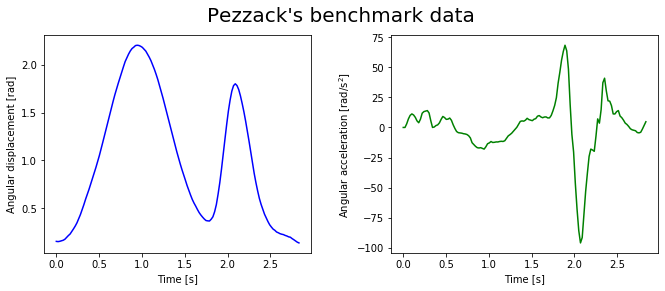

In [2]:
# load data file
time, disp, disp2, aacc = np.loadtxt('./../data/Pezzack.txt', skiprows=6, unpack=True)
dt = np.mean(np.diff(time))
# plot data
fig, (ax1,ax2) = plt.subplots(1, 2, sharex = True, figsize=(11, 4))
plt.suptitle("Pezzack's benchmark data", fontsize=20)
ax1.plot(time, disp, 'b')
ax1.set_xlabel('Time [s]'); ax1.set_ylabel('Angular displacement [rad]')
ax2.plot(time, aacc, 'g')
ax2.set_xlabel('Time [s]'); ax2.set_ylabel('Angular acceleration [rad/s$^2$]')
plt.subplots_adjust(wspace=0.3)

And using the residual analsysis code:

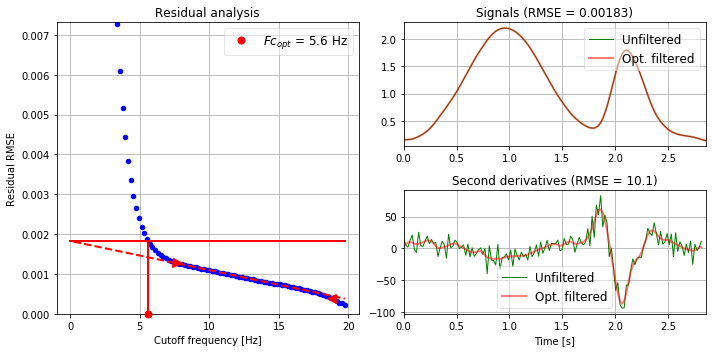

In [3]:
from optcutfreq import optcutfreq

freq = np.mean(1/np.diff(time))
fc_opt = optcutfreq(disp, freq=freq, show=True)

The optimal cutoff frequency found is 5.6 Hz. Note that the filtering process is relevant only for the derivative of the data; we cannot distinguish the unfiltered and unfiltered displacements (see that the RMSE residual is very small).   
Let's employ this filter, differentiate the data twice and compare with the true acceleration as we did before:

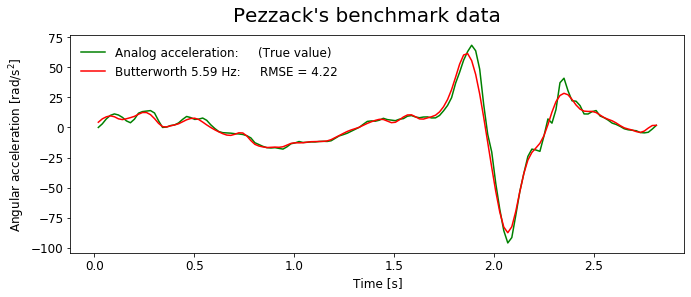

In [4]:
from scipy.signal import butter, filtfilt
# Butterworth filter
# Correct the cutoff frequency for the number of passes in the filter
C = 0.802 # for dual pass; C = (2**(1/npasses) - 1)**0.25
b, a = butter(2, (fc_opt/C)/(freq/2))
dispf = filtfilt(b, a, disp)
aaccBW =  np.diff(dispf, 2)*freq*freq
# RMSE:
rmseBW = np.sqrt(np.mean((aaccBW-aacc[1:-1])**2))
# plot data
fig, ax1 = plt.subplots(1, 1, figsize=(11, 4))
plt.suptitle("Pezzack's benchmark data", fontsize=20)
ax1.plot(time[1:-1], aacc[1:-1], 'g', label='Analog acceleration:     (True value)')
ax1.plot(time[1:-1], aaccBW, 'r', 
         label='Butterworth %.3g Hz:     RMSE = %0.2f' %(fc_opt,rmseBW))
ax1.set_xlabel('Time [s]');
ax1.set_ylabel('Angular acceleration [rad/s$^2$]');
plt.legend(frameon=False, fontsize=12, loc='upper left');

The performance seems satisfactory (see [this Jupyter notebook](http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DataFiltering.ipynb) for a comparison using other filters), but it is known that this residual analysis algorithm results in oversmoothing the kinematic data (see  [http://www.clinicalgaitanalysis.com/faq/cutoff.html](http://www.clinicalgaitanalysis.com/faq/cutoff.html)).

To read more about the determination of the optimal cutoff frequency, see the following papers:  

- Pezzack, Norman, & Winter (1977). [An assessment of derivative determining techniques used for motion analysis](http://www.health.uottawa.ca/biomech/courses/apa7305/JB-Pezzack-Norman-Winter-1977.pdf). Journal of Biomechanics, 10, 377-382.
- Giakas & Baltizopoulos (1997) [A comparison of automatic filtering techniques applied to biomechanical walking data](http://www.pe.uth.gr/sk_cms/scriptlib/getblob.php?redir=../sk_cms/images/notfound.htm&table=pepublications&field=doc&id=30). J. Biomech. 30, 847-850.
- Alonso, Salgado, Cuadrado & Pintado (2009) [Automatic smoothing of raw kinematic signals using SSA and cluster analysis](http://lim.ii.udc.es/docs/proceedings/2009_09_EUROMECH_Automatic.pdf). 7th EUROMECH Solid Mechanics Conference.
- Kristianslund, Krosshaug & Bogert (2012) [Effect of low pass filtering on joint moments from inverse dynamics: Implications for injury prevention](http://www.klokavskade.no/upload/Publication/Kristianslund_2012_J%20Biomechan_Effect%20of%20low-pass%20filtering%20on%20joint%20moments%20from%20inverse%20dynamics.pdf). J. Biomech. 45, 666-671.

## References

- Pezzack JC, Norman RW, & Winter DA (1977). [An assessment of derivative determining techniques used for motion analysis](http://www.health.uottawa.ca/biomech/courses/apa7305/JB-Pezzack-Norman-Winter-1977.pdf). Journal of Biomechanics, 10, 377-382. [PubMed](http://www.ncbi.nlm.nih.gov/pubmed/893476).
- Winter DA (2009) [Biomechanics and motor control of human movement](http://books.google.com.br/books?id=_bFHL08IWfwC&printsec=frontcover&source=gbs_ge_summary_r&cad=0#v=onepage&q&f=false). 4 ed. Hoboken, EUA: Wiley.